In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [3]:
data = pd.read_csv("eleicoes_2006_a_2010.csv")

matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)

In [4]:
data.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f388759ccc0>,
      dtype=object)

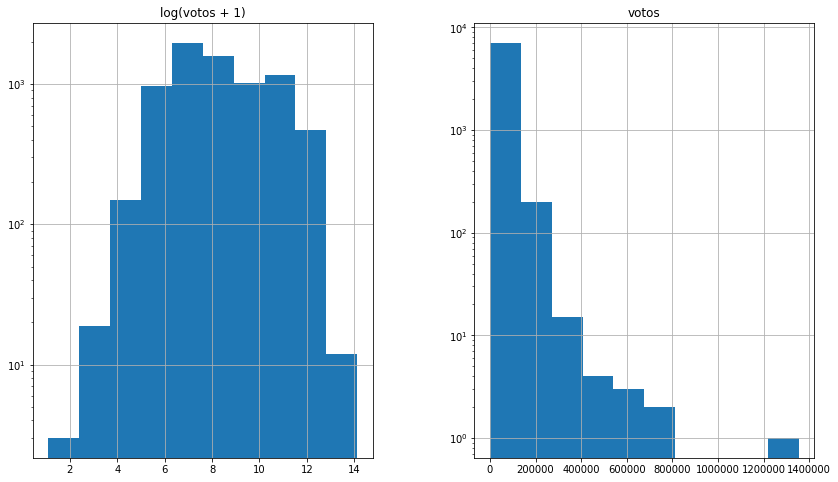

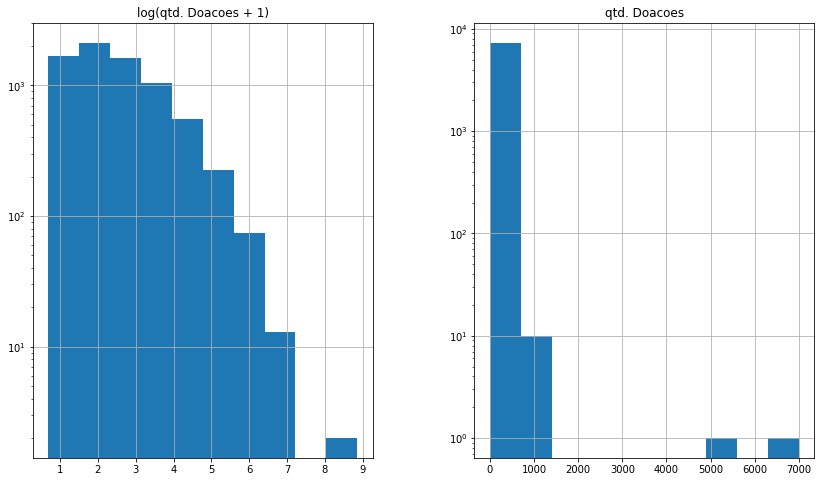

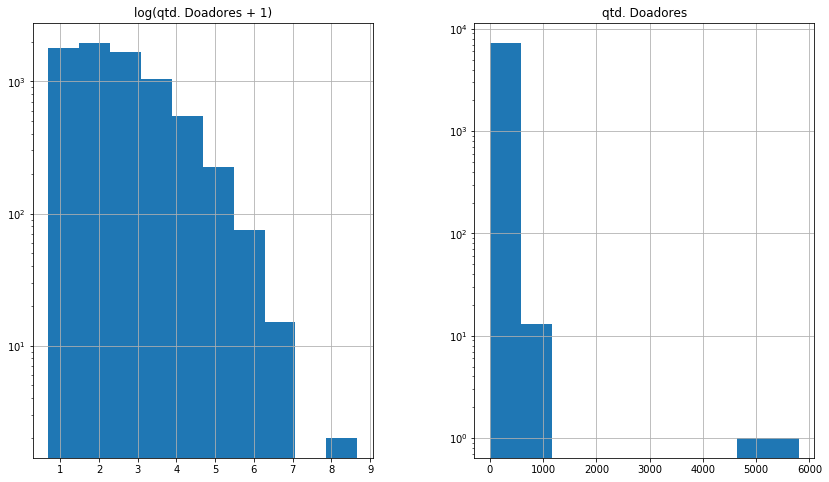

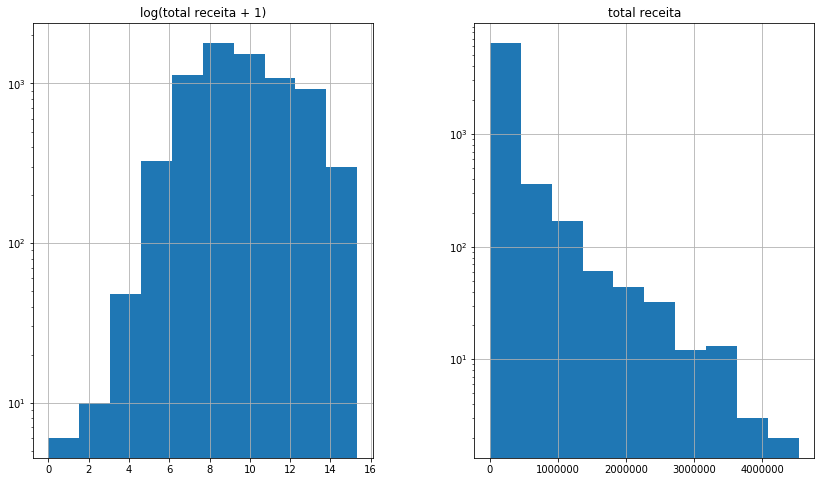

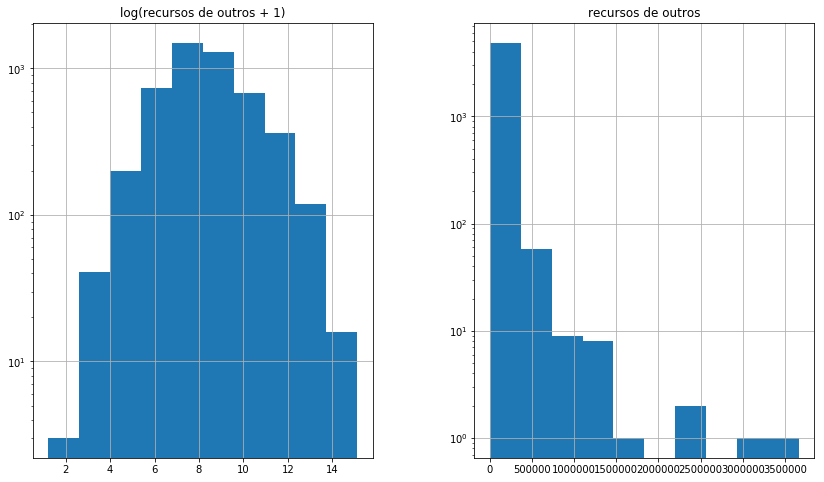

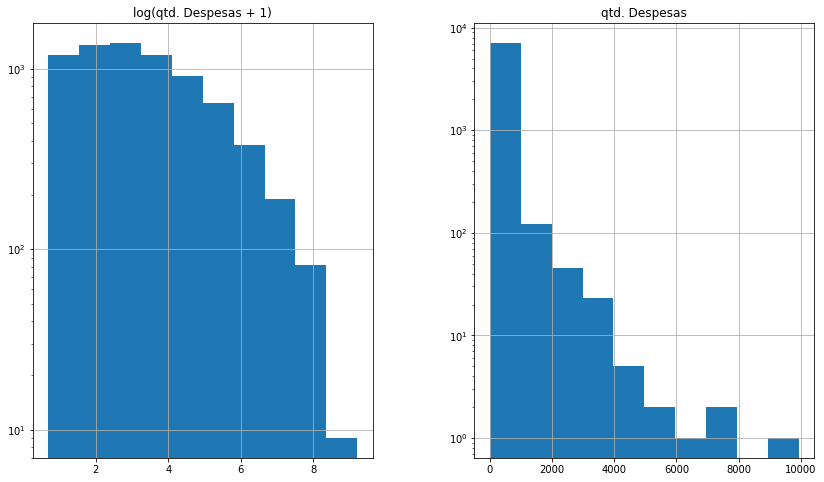

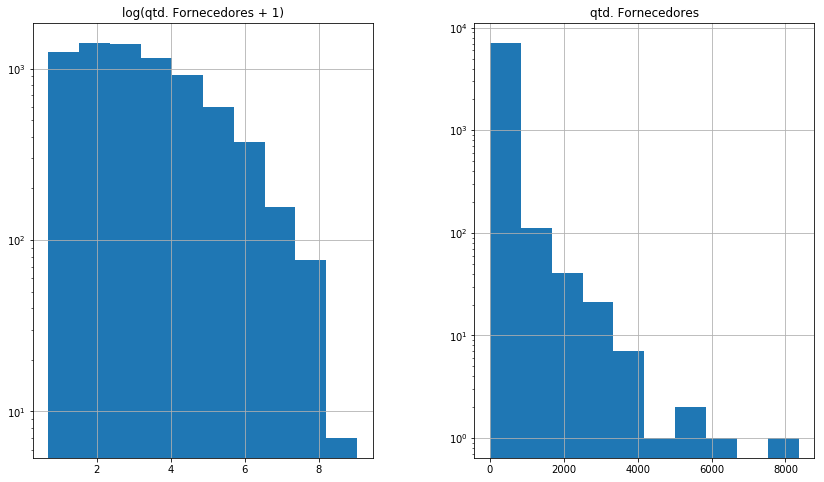

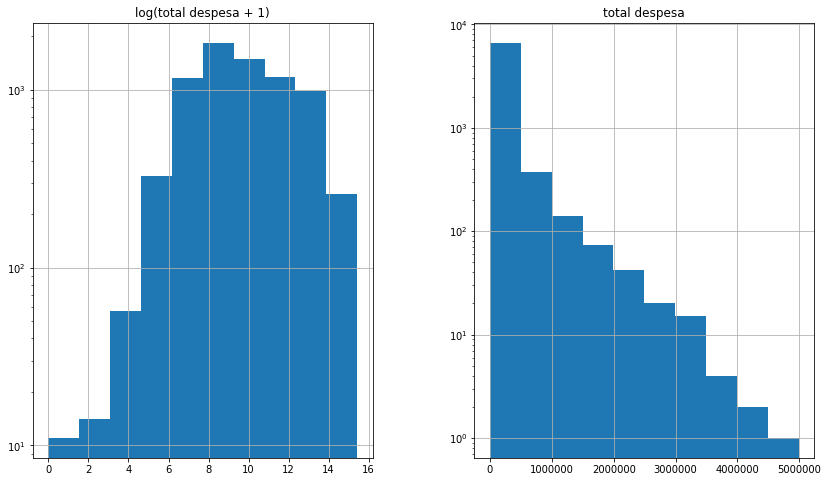

In [5]:
df_votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])})
df_votos.hist(log=True)

df_qtdDoacoes = pd.DataFrame({"qtd. Doacoes":data["quantidade_doacoes"], "log(qtd. Doacoes + 1)":np.log1p(data["quantidade_doacoes"])})
df_qtdDoacoes.hist(log=True)

df_qtdDoadores = pd.DataFrame({"qtd. Doadores":data["quantidade_doadores"], "log(qtd. Doadores + 1)":np.log1p(data["quantidade_doadores"])})
df_qtdDoadores.hist(log=True)

df_totalReceita = pd.DataFrame({"total receita":data["total_receita"], "log(total receita + 1)":np.log1p(data["total_receita"])})
df_totalReceita.hist(log=True)

df_recursosOutros = pd.DataFrame({"recursos de outros":data["recursos_de_outros_candidatos/comites"], "log(recursos de outros + 1)":np.log1p(data["recursos_de_outros_candidatos/comites"])})
df_recursosOutros.hist(log=True)

df_qtdDespesas = pd.DataFrame({"qtd. Despesas":data["quantidade_despesas"], "log(qtd. Despesas + 1)":np.log1p(data["quantidade_despesas"])})
df_qtdDespesas.hist(log=True)

df_qtdFornecedores = pd.DataFrame({"qtd. Fornecedores":data["quantidade_fornecedores"], "log(qtd. Fornecedores + 1)":np.log1p(data["quantidade_fornecedores"])})
df_qtdFornecedores.hist(log=True)

df_totalDespesas = pd.DataFrame({"total despesa":data["total_despesa"], "log(total despesa + 1)":np.log1p(data["total_despesa"])})
df_totalDespesas.hist(log=True)

In [6]:
data = data.drop(columns=['media_receita','media_despesa','nome'])
data.head()

,ano,sequencial_candidato,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,AP,PT,6,6,16600.00,NaN,9000.0,6300.00,1300.0,14,14,16583.60,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,RO,PT,13,13,22826.00,6625.0,15000.0,1000.00,201.0,24,23,20325.99,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,AP,PT,17,16,148120.80,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,MS,PRONA,6,6,3001.12,NaN,1150.0,1101.12,750.0,8,8,3001.12,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,RO,PT,48,48,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


Removendo as colunas "media_receita" e "media_despesa", pois elas são derivadas da divisão de "total_receita" por "quantidade_doadores" e "total_despesa" por "quantidade_fornecedores", respectivamente.

In [7]:
#log transform skewed numeric features
numeric_feats = data.dtypes[data.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano') #não aplico normalização na variável ano pois ela é ordinal

data[numeric_feats] = np.log1p(data[numeric_feats])

data = data.drop(columns=['sequencial_candidato'])

Aplicando normalização em todas as variáveis numéricas, exceto ano, pois apesar de ela ser um número, a considerei ordinal em vez de numérica.

In [8]:
from sklearn.model_selection import train_test_split
entradas = data.loc[:,:'ocupacao']
saida = data.loc[:,'votos']

entradas = entradas.fillna(entradas.mean())
entradas = pd.get_dummies(entradas)

X_train, X_test, Y_train, Y_test = train_test_split(entradas,saida)

dividindo os dados em dados de treino e teste aleatoriamente, com proporção de 75% para treino e 25% para validação.

Aplicando a função dummy nas variáveis categóricas e preenchendo os registros vazios com a mediana da coluna.

## Regressões lineares
### Não regularizada

In [9]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

reg_linear = LinearRegression()
reg_linear.fit(X_train, Y_train)

print(rmse_cv(reg_linear).mean())

601795785.2886574


Text(0,0.5,'rmse')

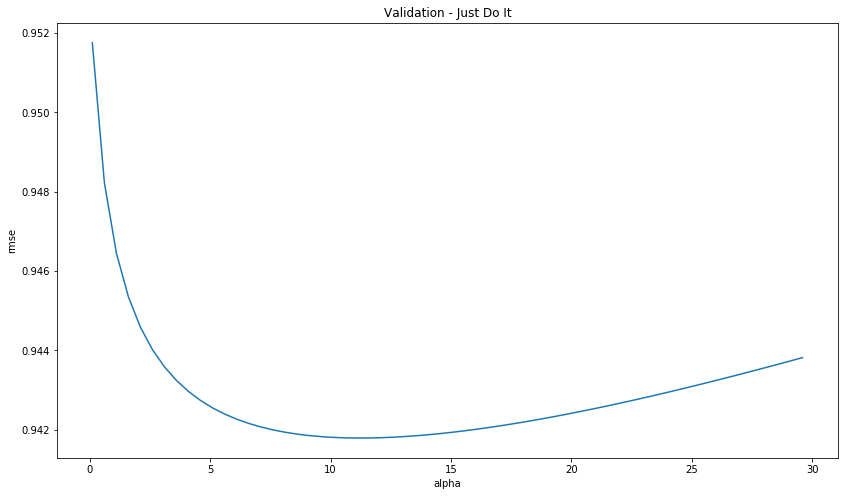

In [20]:
alphas_ridge = np.arange(0.1,30,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)
cv_ridge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

Text(0,0.5,'rmse')

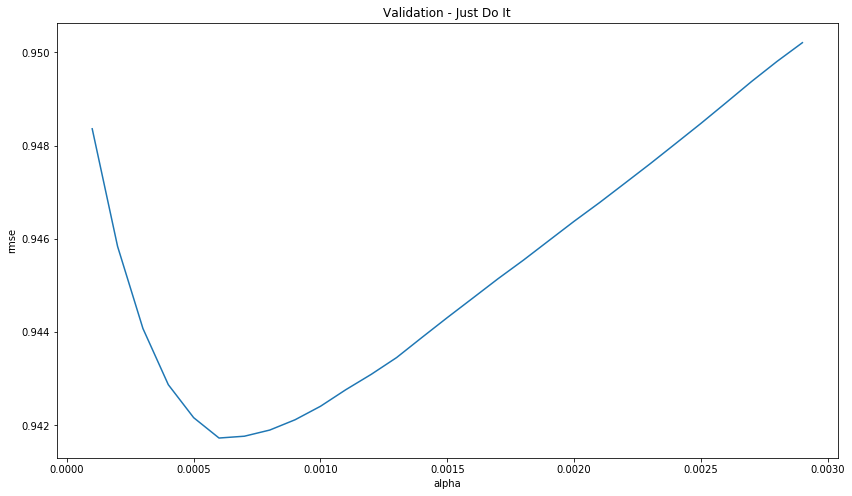

In [21]:
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()

cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean()
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

Text(0,0.5,'rmse')

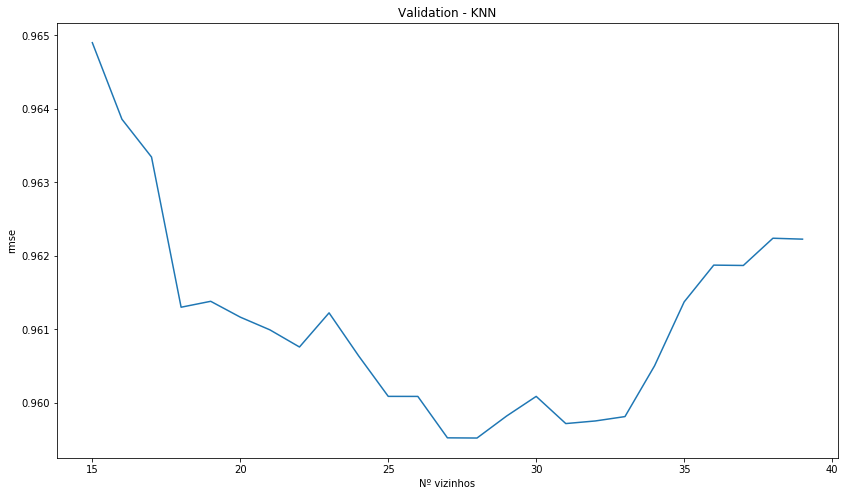

In [34]:
from sklearn.neighbors import KNeighborsRegressor

k_list = np.arange(15,40,1).tolist()

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = n)).mean()
            for n in k_list]

cv_knn = pd.Series(cv_knn, index = k_list)
cv_knn.plot(title = "Validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("rmse")

Text(0,0.5,'rmse')

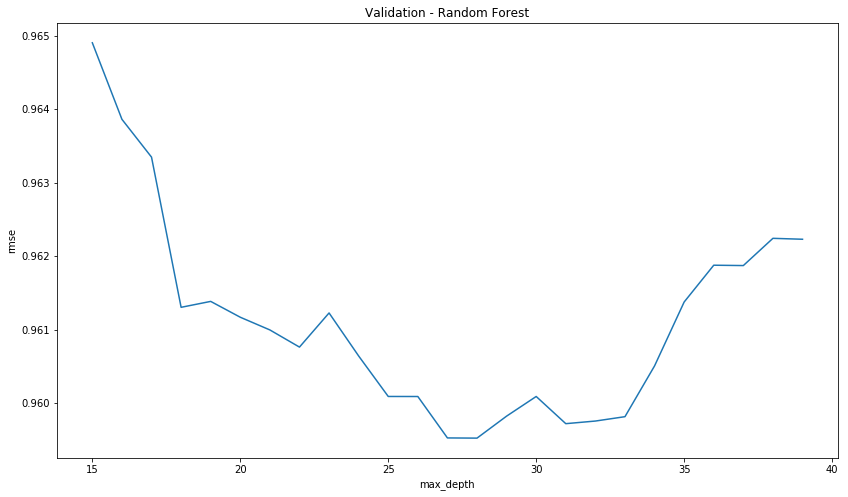

In [38]:
from sklearn.ensemble import RandomForestRegressor

depth_list = np.arange(2,10,1).tolist()

cv_forest = [rmse_cv(RandomForestRegressor(max_depth = max_depth, n_estimators=100)).mean()
            for max_depth in depth_list]

cv_forest = pd.Series(cv_knn, index = k_list)
cv_forest.plot(title = "Validation - Random Forest (nº estimators = 100)")
plt.xlabel("max_depth")
plt.ylabel("rmse")

In [40]:
estimators_list = np.arange(500,800,100).tolist()

cv_forest = [rmse_cv(RandomForestRegressor(max_depth = 27, n_estimators = n_estimators)).mean()
            for n_estimators in estimators_list]

cv_forest = pd.Series(cv_knn, index = estimators_list)
cv_forest.plot(title = "Validation - Random Forest (depth = 27)")
plt.xlabel("nº estimators")
plt.ylabel("rmse")

KeyboardInterrupt: 